In [1]:
import numpy as np
import HamiltonianPy as hp
import HamiltonianPy.FBFM as fb
import itertools as it
from scipy.linalg import eigh
from numpy.linalg import eigvalsh
from scipy.integrate import quad
from collections import OrderedDict
from fractions import Fraction

In [2]:
bose = lambda t, e: 1/(np.exp(e/t)-1)
coeff = lambda n: quad(lambda x: (np.log((1+x)/x))**2, 0, n)[0]
def iscontinuum(es, region):
    dEs = (es[1:]-es[:-1])
    result = dEs[region] < np.sum(dEs[region+1:])
    return result

class TH(hp.App):
    def __init__(self, BZ, ns, T=None, scalefree=1.0, scaleint=1.0, ncontinuum=None, **kwargs):
        self.BZ = BZ
        self.ns = ns
        self.T = T
        self.scalefree = scalefree
        self.scaleint = scaleint
        self.ncontinuum = ncontinuum
        self.emesh = {}
        self.vmesh = {}
        self.cmesh = {}
        self.jmesh = {}

    def set(self, H):
        assert len(self.BZ.type.periods) == 2
        N1, N2 = self.BZ.type.periods
        for (i, j) in it.product(range(N1), range(N2)):
            es, vs = eigh(H(i, j))
            if isinstance(self.ncontinuum, int):
                self.jmesh[(i, j)] = iscontinuum(es[0:self.ncontinuum+10], self.ncontinuum)
            else:
                self.jmesh[(i, j)] = False
            self.emesh[(i, j)] = es[self.ns]
            self.vmesh[(i, j)] = vs[:, self.ns]
        phases = np.zeros(len(self.ns), dtype=np.float64)
        for (i, j) in it.product(range(N1), range(N2)):
            #i1, j1 = (i-1)%N1, (j-1)%N2
            i1, j1 = i, j
            i2, j2 = (i+1)%N1, (j+1)%N2
            ic = self.jmesh[(i, j)]
            vs1, vs2, vs3, vs4 = self.vmesh[(i1, j1)], self.vmesh[(i2, j1)], self.vmesh[(i2, j2)], self.vmesh[(i1, j2)]
            self.cmesh[(i, j)] = np.zeros(phases.shape, dtype=np.float64)
            for (k, n) in enumerate(self.ns):
                if n<self.ncontinuum or not ic:
                    p1, p2 = np.vdot(vs1[:, k], vs2[:, k]), np.vdot(vs2[:, k], vs3[:, k])
                    p3, p4 = np.vdot(vs3[:, k], vs4[:, k]), np.vdot(vs4[:, k], vs1[:, k])
                    # phase = np.angle(p1*p2*p3*p4)/4
                    phase = np.angle(p1*p2*p3*p4)
                    self.cmesh[(i, j)][k] = phase
                    phases[k] += phase
        return phases/np.pi/2

    def compute(self):
        result = 0.0
        N1, N2 = self.BZ.type.periods
        for (i, j) in it.product(range(N1), range(N2)):
            es, cs = self.emesh[(i, j)], self.cmesh[(i, j)]
            for k in range(len(es)):
                result += coeff(bose(self.T, es[k]))*cs[k]
        return result*self.T

    def curvature(self):
        N1, N2 = self.BZ.type.periods
        result = np.zeros((N1, N2, len(self.ns)+2))
        for (i, j) in it.product(range(N1), range(N2)):
            kx, ky = self.BZ.kcoord((i, j))
            result[i, j, 0] = kx
            result[i, j, 1] = ky
            result[i, j , 2:] = self.cmesh[(i, j)]
        return result

def FBFMTHC(engine, app):
    name = '%s_%s(%s,%s)'%(engine.tostr(), app.name, app.scalefree, app.scaleint)
    engine.log<<('%s: \n'%name)
    phases = app.set(lambda i, j: engine.matrix(k=(i, j), scalefree=app.scalefree, scaleint=app.scaleint))
    engine.log<<('phases: %s\n'%phases)
    result = app.curvature()
    if app.savedata: np.savetxt('%s/%s.dat'%(engine.dout, name), result.reshape((-1, len(app.ns)+2)))
    if app.plot:
        import matplotlib.pyplot as plt
        plt.colorbar(plt.pcolormesh(result[:,:,0], result[:,:,1], result[:,:,2]))
        plt.axis('equal')
        if app.show and app.suspend: plt.show()
        if app.show and not app.suspend: plt.pause(hp.App.SUSPEND_TIME)
        if app.savefig: plt.savefig('%s/%s.png'%(engine.dout, name))
    if app.returndata: return result

class THT(hp.App):
    def __init__(self, Ts, **kwargs):
        self.Ts = Ts

def FBFMTHT(engine, app):
    hall = engine.apps[app.dependences[0]]
    name='%s_%s(%s,%s)'%(engine.tostr(), app.name, hall.scalefree, hall.scaleint)
    engine.log<<('%s: \n'%name)
    phases = hall.set(lambda i, j: engine.matrix(k=(i, j),scalefree=hall.scalefree,scaleint=hall.scaleint))
    engine.log<<('phases: %s\n'%phases)
    result = np.zeros((len(app.Ts), 2), dtype=np.float64)
    for i, T in enumerate(app.Ts):
        engine.log<<('%s, '%T)
        hall.T = T
        result[i, 0] = T
        result[i, 1] = hall.compute()
    engine.log<<('\n')
    if app.savedata: np.savetxt('%s/%s.dat'%(engine.dout, name), result)
    if app.plot: app.figure('L', result, '%s/%s'%(engine.dout, name))
    if app.returndata: return result

class THP(hp.App):
    def __init__(self, params, **kwargs):
        self.params = params

def FBFMTHP(engine, app):
    hall = engine.apps[app.dependences[0]]
    result = np.zeros((app.params.rank(0), 2), dtype=np.float64)
    name='%s_%s(%s,%s)_%s'%(engine.tostr(mask=app.params.tags), app.name, hall.scalefree, hall.scaleint, hall.T)
    engine.log<<('%s: \n'%name)
    for i, param in enumerate(app.params('+')):
        engine.log<<("%s: "%param)
        engine.update(**param)
        engine.tostr(mask=app.params.tags)
        phases = hall.set(lambda i, j: engine.matrix(k=(i, j),scalefree=hall.scalefree,scaleint=hall.scaleint))
        engine.log<<("%s\n"%phases)
        result[i, 0] = list(param.values())[0]
        result[i, 1] = hall.compute()
    engine.log<<'\n'
    if app.savedata: np.savetxt('%s/%s.dat'%(engine.dout, name), result)
    if app.plot: app.figure('L', result, '%s/%s'%(engine.dout, name))
    if app.returndata: return result

def FBFMEB(engine,app):
    path, ne = app.path, min(app.ne or engine.nmatrix, engine.nmatrix)
    bz, reciprocals = engine.basis.BZ, engine.lattice.reciprocals
    if not isinstance(path, hp.BaseSpace): path = bz.path(hp.KMap(reciprocals,path) if isinstance(path,str) else path, mode='Q')
    result = np.zeros((path.rank(0), ne+1))
    result[:, 0] = path.mesh(0) if path.mesh(0).ndim==1 else np.array(range(path.rank(0)))
    engine.log<<'%s: '%path.rank(0)
    for i,paras in enumerate(path('+')):
        engine.log<<'%s%s'%(i,'..' if i<path.rank(0)-1 else '')
        m = engine.matrix(scalefree=app.scalefree, scaleint=app.scaleint, **paras)
        es = eigvalsh(m)
        if iscontinuum(es[0:8], 1):
            es[1:ne] = np.NaN
        result[i, 1:] = es[:ne]
    engine.log<<'\n'
    name='%s_%s%s'%(engine.tostr(mask=path.tags),app.name,app.suffix)
    if app.savedata: np.savetxt('%s/%s.dat'%(engine.dout,name),result)
    if app.plot: app.figure('L',result,'%s/%s'%(engine.dout,name))
    if app.returndata: return result

In [3]:
name="HCI"
lattice = hp.Hexagon('H2')('1P-1P', 2)

idfmap=lambda pid: hp.Fock(atom=pid.site%2,nspin=2,norbital=1,nnambu=1)

def haldane(bond,phi):
    assert bond.spoint.pid.site%2==bond.epoint.pid.site%2
    phase,theta,site=np.exp(1.0j*phi),hp.azimuthd(bond.rcoord),bond.epoint.pid.site%2
    if np.allclose(theta,60) or np.allclose(theta,180) or np.allclose(theta,300):
        result=phase
    else:
        result=phase.conjugate()
    if site==1: result=result.conjugate()
    return hp.FockPack(value=result,spins=(0,0))+hp.FockPack(value=result,spins=(1,1))

t=lambda **parameters: hp.Hopping('t1',parameters['t1'],neighbour=1,statistics='f')
ci=lambda **parameters: hp.Hopping('t2',parameters['t2'],neighbour=2,indexpacks=lambda bond: haldane(bond,parameters['phi']),modulate=True)
Ua=lambda **parameters: hp.Hubbard('Ua',parameters['Ua'],atom=0,modulate=True)
Ub=lambda **parameters: hp.Hubbard('Ub',parameters['Ub'],atom=1,modulate=True)

def fbfmtasks(name, parameters, lattice, terms, interactions, nk, scalefree=1.0,scaleint=1.0, jobs=(), **kwargs):
    ns, ne = len(lattice), len(lattice)//2
    basis = fb.FBFMBasis(BZ=hp.FBZ(lattice.reciprocals, nks=(nk,nk)), filling=Fraction(ne, ns*2))
    fbfm=fb.FBFM(
        dlog=           'log',
        din=            'data',
        dout=           'result/thermal',
        name=           '%s_%s_%s'%(name, lattice.name, basis.polarization),
        parameters=     parameters,
        basis=          basis,
        lattice=        lattice,
        config=         hp.IDFConfig(priority=fb.FBFM_PRIORITY, pids=lattice.pids, map=idfmap),
        terms=          [term(**parameters) for term in terms],
        interactions=   [term(**parameters) for term in interactions],
        dtype=          np.complex128)
    if 'EB' in jobs: fbfm.register(fb.EB(name='EB%s'%nk, path='H:G-K1,K1-M1,M1-K2,K2-G', ne=nk**2, run=fb.FBFMEB, savefig=False))
    if 'FEB' in jobs: fbfm.register(fb.EB(name='FEB%s'%nk, path='H:G-K1,K1-M1,M1-K2,K2-G', ne=10, run=FBFMEB, savefig=False))
    if 'THC' in jobs:
        ns = kwargs.get('ns', [0])
        fbfm.register(TH(name='THC%s'%nk, BZ=basis.BZ, ns=ns, ncontinuum=1, scalefree=scalefree, scaleint=scaleint, run=FBFMTHC))
    if 'THP' in jobs:
        ns = kwargs.get('ns', [0, 1])
        T = kwargs.get('T', 0.01)
        params = kwargs.get('params', hp.BaseSpace(('t2', np.linspace(0.29, 0.32, 31))))
        fbfm.add(TH(name='TH%s'%nk, BZ=basis.BZ, ns=ns, ncontinuum=1, T=T, scalefree=scalefree, scaleint=scaleint))
        fbfm.register(THP(name='THP%s'%nk, params=params, dependences=['TH%s'%nk], run=FBFMTHP, savedata=True, savefig=False))
    if 'THT' in jobs:
        ns = kwargs.get('ns', [0, 1])
        params = kwargs.get('params', np.linspace(0.002,0.050, 49))
        fbfm.add(TH(name='TH%s'%nk, BZ=basis.BZ, ns=ns, ncontinuum=1, scalefree=scalefree, scaleint=scaleint))
        fbfm.register(THT(name='THT%s'%nk, Ts=params, dependences=['TH%s'%nk], run=FBFMTHT, savedata=True, savefig=False))
    return fbfm

31: 0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30


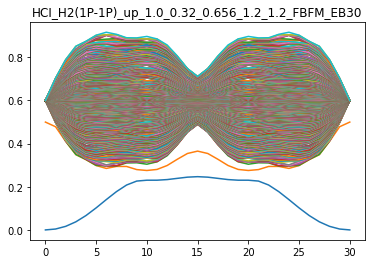

App EB30(EB): time consumed 10.509974479675293s.


In [4]:
delta=0.0
parameters=OrderedDict()
parameters['t1']=1.0
parameters['t2']=0.32
parameters['phi']=0.656
parameters['Ua']=1.2
parameters['Ub']=parameters['Ua']-delta

fbfm = fbfmtasks(name, parameters, lattice, [t, ci], [Ua, Ub], nk=30, jobs=['EB'])

31: 0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30


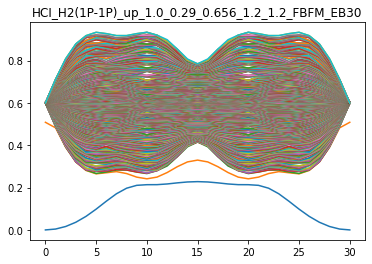

App EB30(EB): time consumed 10.649662017822266s.


In [5]:
delta=0.0
parameters=OrderedDict()
parameters['t1']=1.0
parameters['t2']=0.29
parameters['phi']=0.656
parameters['Ua']=1.2
parameters['Ub']=parameters['Ua']-delta

fbfm = fbfmtasks(name, parameters, lattice, [t, ci], [Ua, Ub], nk=30, jobs=['EB'])

31: 0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30


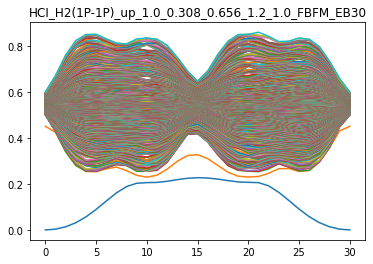

App EB30(EB): time consumed 10.432677984237671s.


In [6]:
delta=0.2
parameters=OrderedDict()
parameters['t1']=1.0
parameters['t2']=0.308
parameters['phi']=0.656
parameters['Ua']=1.2
parameters['Ub']=parameters['Ua']-delta

fbfm = fbfmtasks(name, parameters, lattice, [t, ci], [Ua, Ub], nk=30, jobs=['EB'])

HCI_H2(1P-1P)_up_1.0_0.32_0.656_1.2_1.2_FBFM_THC30(1.0,1.0): 
phases: [-1.]


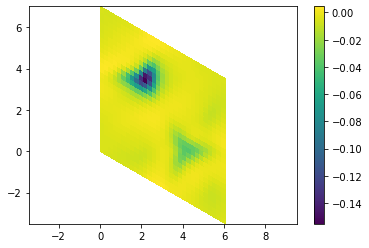

App THC30(TH): time consumed 332.4103813171387s.


<Figure size 432x288 with 0 Axes>

In [13]:
delta=0.0
parameters=OrderedDict()
parameters['t1']=1.0
parameters['t2']=0.32
parameters['phi']=0.656
parameters['Ua']=1.2
parameters['Ub']=parameters['Ua']-delta

# fbfm = fbfmtasks(name, parameters, lattice, [t, ci], [Ua, Ub], nk=24, jobs=['EB'])
fbfm = fbfmtasks(name, parameters, lattice, [t, ci], [Ua, Ub], nk=30, scalefree=1.0, scaleint=1.0, ns=[0,], jobs=['THC'])

HCI_H2(1P-1P)_up_1.0_0.29_0.656_1.2_1.2_FBFM_THC30(1.0,1.0): 
phases: [1.]


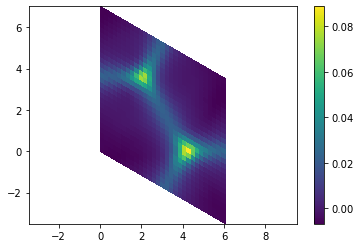

App THC30(TH): time consumed 324.41110038757324s.


<Figure size 432x288 with 0 Axes>

In [14]:
delta=0.0
parameters=OrderedDict()
parameters['t1']=1.0
parameters['t2']=0.29
parameters['phi']=0.656
parameters['Ua']=1.2
parameters['Ub']=parameters['Ua']-delta

# fbfm = fbfmtasks(name, parameters, lattice, [t, ci], [Ua, Ub], nk=24, jobs=['EB'])
fbfm = fbfmtasks(name, parameters, lattice, [t, ci], [Ua, Ub], nk=30, scalefree=1.0, scaleint=1.0, ns=[0,], jobs=['THC'])

HCI_H2(1P-1P)_up_1.0_0.308_0.656_1.2_1.0_FBFM_THC30(1.0,1.0): 
phases: [-1.5074504e-16]


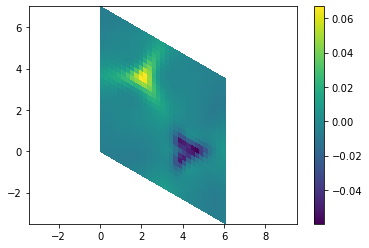

App THC30(TH): time consumed 330.09174275398254s.


<Figure size 432x288 with 0 Axes>

In [15]:
delta=0.2
parameters=OrderedDict()
parameters['t1']=1.0
parameters['t2']=0.308
parameters['phi']=0.656
parameters['Ua']=1.2
parameters['Ub']=parameters['Ua']-delta

# fbfm = fbfmtasks(name, parameters, lattice, [t, ci], [Ua, Ub], nk=24, jobs=['EB'])
fbfm = fbfmtasks(name, parameters, lattice, [t, ci], [Ua, Ub], nk=30, scalefree=1.0, scaleint=1.0, ns=[0,], jobs=['THC'])

In [4]:
delta=0.0
parameters=OrderedDict()
parameters['t1']=1.0
parameters['t2']=0.32
parameters['phi']=0.656
parameters['Ua']=1.2
parameters['Ub']=parameters['Ua']-delta

HCI_H2(1P-1P)_up_1.0_0.32_0.656_1.2_1.2_FBFM_THT18(1.0,1.0): 
phases: [-1.]
0.002, 0.004, 0.006, 0.008, 0.01, 0.012, 0.014, 0.016, 0.018000000000000002, 0.020000000000000004, 0.022, 0.024, 0.026000000000000002, 0.028000000000000004, 0.03, 0.032, 0.034, 0.036000000000000004, 0.038000000000000006, 0.04, 0.042, 0.044000000000000004, 0.046, 0.048, 0.05, 0.052000000000000005, 0.054000000000000006, 0.056, 0.058, 0.060000000000000005, 0.062, 0.064, 0.066, 0.068, 0.07, 0.07200000000000001, 0.07400000000000001, 0.076, 0.078, 0.08, 


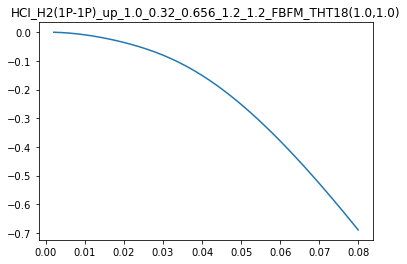

App THT18(THT): time consumed 19.17323613166809s.


In [5]:
params = np.linspace(0.002, 0.080, 40)
fbfmtasks(name, parameters, lattice, [t,ci], [Ua,Ub], nk=18,scalefree=1.0, scaleint=1.0, jobs=['THT'], ns=[0,], params=params)

HCI_H2(1P-1P)_up_1.0_0.32_0.656_1.2_1.2_FBFM_THT24(1.0,1.0): 
phases: [-1.]
0.002, 0.004, 0.006, 0.008, 0.01, 0.012, 0.014, 0.016, 0.018000000000000002, 0.020000000000000004, 0.022, 0.024, 0.026000000000000002, 0.028000000000000004, 0.03, 0.032, 0.034, 0.036000000000000004, 0.038000000000000006, 0.04, 0.042, 0.044000000000000004, 0.046, 0.048, 0.05, 0.052000000000000005, 0.054000000000000006, 0.056, 0.058, 0.060000000000000005, 0.062, 0.064, 0.066, 0.068, 0.07, 0.07200000000000001, 0.07400000000000001, 0.076, 0.078, 0.08, 


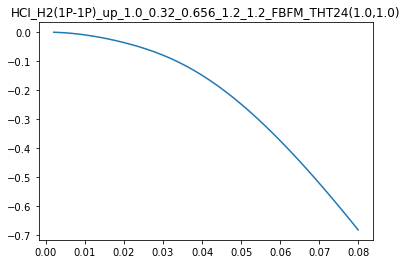

App THT24(THT): time consumed 82.52214884757996s.


In [6]:
params = np.linspace(0.002, 0.080, 40)
fbfmtasks(name, parameters, lattice, [t,ci], [Ua,Ub], nk=24, scalefree=1.0, scaleint=1.0, jobs=['THT'], ns=[0,], params=params)

HCI_H2(1P-1P)_up_1.0_0.32_0.656_1.2_1.2_FBFM_THT30(1.0,1.0): 
phases: [-1.]
0.002, 0.004, 0.006, 0.008, 0.01, 0.012, 0.014, 0.016, 0.018000000000000002, 0.020000000000000004, 0.022, 0.024, 0.026000000000000002, 0.028000000000000004, 0.03, 0.032, 0.034, 0.036000000000000004, 0.038000000000000006, 0.04, 0.042, 0.044000000000000004, 0.046, 0.048, 0.05, 0.052000000000000005, 0.054000000000000006, 0.056, 0.058, 0.060000000000000005, 0.062, 0.064, 0.066, 0.068, 0.07, 0.07200000000000001, 0.07400000000000001, 0.076, 0.078, 0.08, 


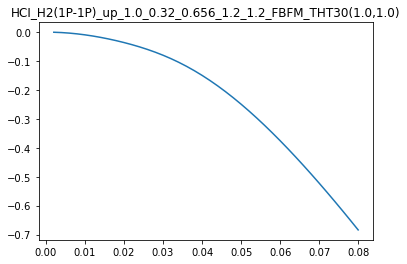

App THT30(THT): time consumed 334.1771173477173s.


In [7]:
params = np.linspace(0.002, 0.080, 40)
fbfmtasks(name, parameters, lattice, [t,ci], [Ua,Ub], nk=30, scalefree=1.0, scaleint=1.0, jobs=['THT'], ns=[0,], params=params)

In [8]:
delta=0.0
parameters=OrderedDict()
parameters['t1']=1.0
parameters['t2']=0.29
parameters['phi']=0.656
parameters['Ua']=1.2
parameters['Ub']=parameters['Ua']-delta

params = np.linspace(0.002, 0.080, 40)

HCI_H2(1P-1P)_up_1.0_0.29_0.656_1.2_1.2_FBFM_THT18(1.0,1.0): 
phases: [1.]
0.002, 0.004, 0.006, 0.008, 0.01, 0.012, 0.014, 0.016, 0.018000000000000002, 0.020000000000000004, 0.022, 0.024, 0.026000000000000002, 0.028000000000000004, 0.03, 0.032, 0.034, 0.036000000000000004, 0.038000000000000006, 0.04, 0.042, 0.044000000000000004, 0.046, 0.048, 0.05, 0.052000000000000005, 0.054000000000000006, 0.056, 0.058, 0.060000000000000005, 0.062, 0.064, 0.066, 0.068, 0.07, 0.07200000000000001, 0.07400000000000001, 0.076, 0.078, 0.08, 


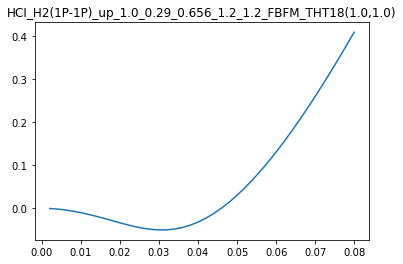

App THT18(THT): time consumed 19.358454704284668s.


In [9]:
fbfmtasks(name, parameters, lattice, [t,ci], [Ua,Ub], nk=18,scalefree=1.0, scaleint=1.0, jobs=['THT'], ns=[0,], params=params)

HCI_H2(1P-1P)_up_1.0_0.29_0.656_1.2_1.2_FBFM_THT24(1.0,1.0): 
phases: [1.]
0.002, 0.004, 0.006, 0.008, 0.01, 0.012, 0.014, 0.016, 0.018000000000000002, 0.020000000000000004, 0.022, 0.024, 0.026000000000000002, 0.028000000000000004, 0.03, 0.032, 0.034, 0.036000000000000004, 0.038000000000000006, 0.04, 0.042, 0.044000000000000004, 0.046, 0.048, 0.05, 0.052000000000000005, 0.054000000000000006, 0.056, 0.058, 0.060000000000000005, 0.062, 0.064, 0.066, 0.068, 0.07, 0.07200000000000001, 0.07400000000000001, 0.076, 0.078, 0.08, 


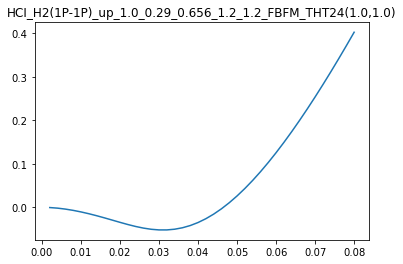

App THT24(THT): time consumed 81.73381471633911s.


In [10]:
fbfmtasks(name, parameters, lattice, [t,ci], [Ua,Ub], nk=24, scalefree=1.0, scaleint=1.0, jobs=['THT'], ns=[0,], params=params)

HCI_H2(1P-1P)_up_1.0_0.29_0.656_1.2_1.2_FBFM_THT30(1.0,1.0): 
phases: [1.]
0.002, 0.004, 0.006, 0.008, 0.01, 0.012, 0.014, 0.016, 0.018000000000000002, 0.020000000000000004, 0.022, 0.024, 0.026000000000000002, 0.028000000000000004, 0.03, 0.032, 0.034, 0.036000000000000004, 0.038000000000000006, 0.04, 0.042, 0.044000000000000004, 0.046, 0.048, 0.05, 0.052000000000000005, 0.054000000000000006, 0.056, 0.058, 0.060000000000000005, 0.062, 0.064, 0.066, 0.068, 0.07, 0.07200000000000001, 0.07400000000000001, 0.076, 0.078, 0.08, 


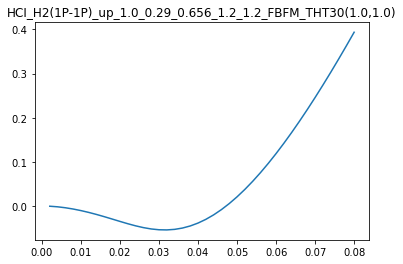

App THT30(THT): time consumed 328.79626059532166s.


In [11]:
fbfmtasks(name, parameters, lattice, [t,ci], [Ua,Ub], nk=30, scalefree=1.0, scaleint=1.0, jobs=['THT'], ns=[0,], params=params)

In [12]:
delta=0.2
parameters=OrderedDict()
parameters['t1']=1.0
parameters['t2']=0.308
parameters['phi']=0.656
parameters['Ua']=1.2
parameters['Ub']=parameters['Ua']-delta

params = np.linspace(0.002, 0.080, 40)

HCI_H2(1P-1P)_up_1.0_0.308_0.656_1.2_1.0_FBFM_THT18(1.0,1.0): 
phases: [-4.44504604e-17]
0.002, 0.004, 0.006, 0.008, 0.01, 0.012, 0.014, 0.016, 0.018000000000000002, 0.020000000000000004, 0.022, 0.024, 0.026000000000000002, 0.028000000000000004, 0.03, 0.032, 0.034, 0.036000000000000004, 0.038000000000000006, 0.04, 0.042, 0.044000000000000004, 0.046, 0.048, 0.05, 0.052000000000000005, 0.054000000000000006, 0.056, 0.058, 0.060000000000000005, 0.062, 0.064, 0.066, 0.068, 0.07, 0.07200000000000001, 0.07400000000000001, 0.076, 0.078, 0.08, 


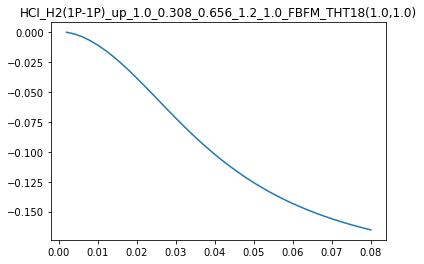

App THT18(THT): time consumed 19.190974712371826s.


In [13]:
fbfmtasks(name, parameters, lattice, [t,ci], [Ua,Ub], nk=18,scalefree=1.0, scaleint=1.0, jobs=['THT'], ns=[0,], params=params)

HCI_H2(1P-1P)_up_1.0_0.308_0.656_1.2_1.0_FBFM_THT24(1.0,1.0): 
phases: [-1.17614262e-16]
0.002, 0.004, 0.006, 0.008, 0.01, 0.012, 0.014, 0.016, 0.018000000000000002, 0.020000000000000004, 0.022, 0.024, 0.026000000000000002, 0.028000000000000004, 0.03, 0.032, 0.034, 0.036000000000000004, 0.038000000000000006, 0.04, 0.042, 0.044000000000000004, 0.046, 0.048, 0.05, 0.052000000000000005, 0.054000000000000006, 0.056, 0.058, 0.060000000000000005, 0.062, 0.064, 0.066, 0.068, 0.07, 0.07200000000000001, 0.07400000000000001, 0.076, 0.078, 0.08, 


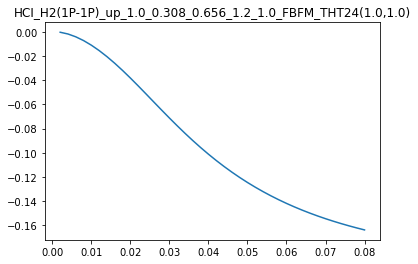

App THT24(THT): time consumed 81.53823208808899s.


In [14]:
fbfmtasks(name, parameters, lattice, [t,ci], [Ua,Ub], nk=24, scalefree=1.0, scaleint=1.0, jobs=['THT'], ns=[0,], params=params)

HCI_H2(1P-1P)_up_1.0_0.308_0.656_1.2_1.0_FBFM_THT30(1.0,1.0): 
phases: [-1.5074504e-16]
0.002, 0.004, 0.006, 0.008, 0.01, 0.012, 0.014, 0.016, 0.018000000000000002, 0.020000000000000004, 0.022, 0.024, 0.026000000000000002, 0.028000000000000004, 0.03, 0.032, 0.034, 0.036000000000000004, 0.038000000000000006, 0.04, 0.042, 0.044000000000000004, 0.046, 0.048, 0.05, 0.052000000000000005, 0.054000000000000006, 0.056, 0.058, 0.060000000000000005, 0.062, 0.064, 0.066, 0.068, 0.07, 0.07200000000000001, 0.07400000000000001, 0.076, 0.078, 0.08, 


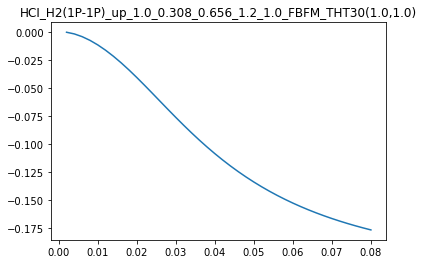

App THT30(THT): time consumed 330.7223937511444s.


In [15]:
fbfmtasks(name, parameters, lattice, [t,ci], [Ua,Ub], nk=30, scalefree=1.0, scaleint=1.0, jobs=['THT'], ns=[0,], params=params)

HCI_H2(1P-1P)_up_1.0_0.656_1.2_1.2_FBFM_THP24(1.0,1.0)_0.08: 
OrderedDict([('t2', 0.29)]): [ 1.         -1.04902425]
OrderedDict([('t2', 0.291)]): [ 1.         -1.04064711]
OrderedDict([('t2', 0.292)]): [ 1.         -1.24628854]
OrderedDict([('t2', 0.293)]): [ 1.         -1.12184096]
OrderedDict([('t2', 0.294)]): [ 1.         -0.99592056]
OrderedDict([('t2', 0.295)]): [ 1.         -1.03637541]
OrderedDict([('t2', 0.296)]): [ 1.        -1.1156029]
OrderedDict([('t2', 0.297)]): [ 1.         -1.07486058]
OrderedDict([('t2', 0.298)]): [ 1.         -1.12601273]
OrderedDict([('t2', 0.299)]): [ 1.         -1.20276469]
OrderedDict([('t2', 0.3)]): [ 1.         -2.24771134]
OrderedDict([('t2', 0.301)]): [ 1.         -2.32028222]
OrderedDict([('t2', 0.302)]): [ 1.         -2.30942054]
OrderedDict([('t2', 0.303)]): [ 1.         -2.38656312]
OrderedDict([('t2', 0.304)]): [ 1.        -2.4050394]
OrderedDict([('t2', 0.305)]): [ 1.        -2.4639222]
OrderedDict([('t2', 0.306)]): [ 1.         -2.47656

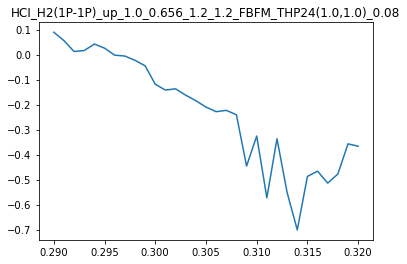

App THP24(THP): time consumed 2224.5677013397217s.


In [56]:
t2tp, t2bt = 0.29, 0.320
fbfmtasks(name, parameters, lattice, [t,ci], [Ua,Ub], nk=24, scalefree=1.0, scaleint=1.0, jobs=['THP'], t2tp=t2tp, t2bt=t2bt)

HCI_H2(1P-1P)_up_1.0_0.656_1.2_1.2_FBFM_THP30(1.0,1.0)_0.08: 
OrderedDict([('t2', 0.29)]): [ 1.         -2.26490192]
OrderedDict([('t2', 0.291)]): [ 1.         -2.19532122]
OrderedDict([('t2', 0.292)]): [ 1.         -3.76787831]
OrderedDict([('t2', 0.293)]): [ 1.         -3.27467113]
OrderedDict([('t2', 0.294)]): [ 1.         -3.52534994]
OrderedDict([('t2', 0.295)]): [ 1.         -3.30182751]
OrderedDict([('t2', 0.296)]): [ 1.        -2.9957594]
OrderedDict([('t2', 0.297)]): [ 1.         -2.36145088]
OrderedDict([('t2', 0.298)]): [ 1.         -2.15353355]
OrderedDict([('t2', 0.299)]): [ 1.         -1.92802914]
OrderedDict([('t2', 0.3)]): [ 1.         -1.79679205]
OrderedDict([('t2', 0.301)]): [ 1.         -1.69303291]
OrderedDict([('t2', 0.302)]): [ 1.         -1.59863544]
OrderedDict([('t2', 0.303)]): [ 1.         -1.91461215]
OrderedDict([('t2', 0.304)]): [ 1.         -1.47110955]
OrderedDict([('t2', 0.305)]): [ 1.         -1.45809783]
OrderedDict([('t2', 0.306)]): [ 1.         -1.4

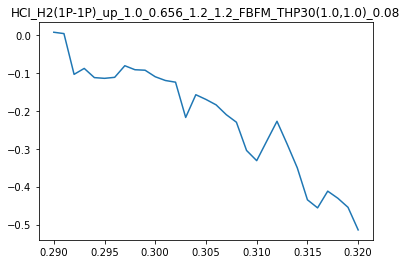

App THP30(THP): time consumed 10094.534541606903s.


In [58]:
t2tp, t2bt = 0.29, 0.320
fbfmtasks(name, parameters, lattice, [t,ci], [Ua,Ub], nk=30, scalefree=1.0, scaleint=1.0, jobs=['THP'], t2tp=t2tp, t2bt=t2bt)

HCI_H2(1P-1P)_up_1.0_0.656_1.2_1.2_FBFM_THP18(1.0,1.0)_0.08: 
OrderedDict([('t2', 0.29)]): [1.]
OrderedDict([('t2', 0.291)]): [1.]
OrderedDict([('t2', 0.292)]): [1.]
OrderedDict([('t2', 0.293)]): [1.]
OrderedDict([('t2', 0.294)]): [1.]
OrderedDict([('t2', 0.295)]): [1.]
OrderedDict([('t2', 0.296)]): [1.]
OrderedDict([('t2', 0.297)]): [1.]
OrderedDict([('t2', 0.298)]): [1.]
OrderedDict([('t2', 0.299)]): [1.]
OrderedDict([('t2', 0.3)]): [1.]
OrderedDict([('t2', 0.301)]): [1.]
OrderedDict([('t2', 0.302)]): [1.]
OrderedDict([('t2', 0.303)]): [1.]
OrderedDict([('t2', 0.304)]): [1.]
OrderedDict([('t2', 0.305)]): [1.]
OrderedDict([('t2', 0.306)]): [1.]
OrderedDict([('t2', 0.307)]): [1.]
OrderedDict([('t2', 0.308)]): [1.]
OrderedDict([('t2', 0.309)]): [-1.]
OrderedDict([('t2', 0.31)]): [-1.]
OrderedDict([('t2', 0.311)]): [-1.]
OrderedDict([('t2', 0.312)]): [-1.]
OrderedDict([('t2', 0.313)]): [-1.]
OrderedDict([('t2', 0.314)]): [-1.]
OrderedDict([('t2', 0.315)]): [-1.]
OrderedDict([('t2', 0.316

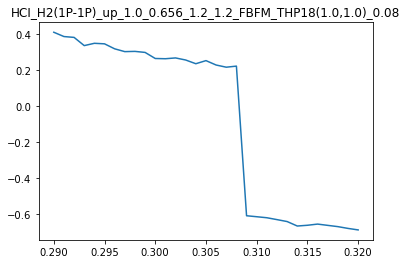

App THP18(THP): time consumed 364.43481516838074s.


In [9]:
T = 0.08
ns = [0]
params = hp.BaseSpace(('t2', np.linspace(0.29, 0.32, 31)))
fbfmtasks(name, parameters, lattice, [t,ci], [Ua,Ub], nk=18, scalefree=1.0, scaleint=1.0, jobs=['THP'], ns=ns, T=T, params=params)

HCI_H2(1P-1P)_up_1.0_0.656_1.2_1.0_FBFM_THP24(1.0,1.0)_0.08: 
OrderedDict([('t2', 0.29)]): [1.]
OrderedDict([('t2', 0.291)]): [1.]
OrderedDict([('t2', 0.292)]): [1.]
OrderedDict([('t2', 0.293)]): [1.]
OrderedDict([('t2', 0.294)]): [1.]
OrderedDict([('t2', 0.295)]): [-6.35006577e-17]
OrderedDict([('t2', 0.296)]): [4.92544232e-16]
OrderedDict([('t2', 0.297)]): [-2.87133409e-17]
OrderedDict([('t2', 0.298)]): [9.41466273e-17]
OrderedDict([('t2', 0.299)]): [2.20595763e-16]
OrderedDict([('t2', 0.3)]): [1.86636716e-16]
OrderedDict([('t2', 0.301)]): [1.68414788e-16]
OrderedDict([('t2', 0.302)]): [-1.94367231e-16]
OrderedDict([('t2', 0.303)]): [7.84095078e-17]
OrderedDict([('t2', 0.304)]): [-1.92986781e-16]
OrderedDict([('t2', 0.305)]): [2.69187571e-16]
OrderedDict([('t2', 0.306)]): [-1.56819016e-16]
OrderedDict([('t2', 0.307)]): [4.96961669e-17]
OrderedDict([('t2', 0.308)]): [-1.17614262e-16]
OrderedDict([('t2', 0.309)]): [-3.23025085e-16]
OrderedDict([('t2', 0.31)]): [1.82771458e-16]
OrderedD

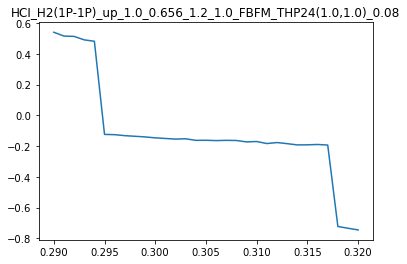

App THP24(THP): time consumed 2142.2818167209625s.


In [16]:
T = 0.08
ns = [0]
params = hp.BaseSpace(('t2', np.linspace(0.29, 0.32, 31)))
fbfmtasks(name, parameters, lattice, [t,ci], [Ua,Ub], nk=24, scalefree=1.0, scaleint=1.0, jobs=['THP'], ns=ns, T=T, params=params)

HCI_H2(1P-1P)_up_1.0_0.656_1.2_1.2_FBFM_THP24(1.0,1.0)_0.08: 
OrderedDict([('t2', 0.29)]): [1.]
OrderedDict([('t2', 0.291)]): [1.]
OrderedDict([('t2', 0.292)]): [1.]
OrderedDict([('t2', 0.293)]): [1.]
OrderedDict([('t2', 0.294)]): [1.]
OrderedDict([('t2', 0.295)]): [1.]
OrderedDict([('t2', 0.296)]): [1.]
OrderedDict([('t2', 0.297)]): [1.]
OrderedDict([('t2', 0.298)]): [1.]
OrderedDict([('t2', 0.299)]): [1.]
OrderedDict([('t2', 0.3)]): [1.]
OrderedDict([('t2', 0.301)]): [1.]
OrderedDict([('t2', 0.302)]): [1.]
OrderedDict([('t2', 0.303)]): [1.]
OrderedDict([('t2', 0.304)]): [1.]
OrderedDict([('t2', 0.305)]): [1.]
OrderedDict([('t2', 0.306)]): [1.]
OrderedDict([('t2', 0.307)]): [1.]
OrderedDict([('t2', 0.308)]): [1.]
OrderedDict([('t2', 0.309)]): [-1.]
OrderedDict([('t2', 0.31)]): [-1.]
OrderedDict([('t2', 0.311)]): [-1.]
OrderedDict([('t2', 0.312)]): [-1.]
OrderedDict([('t2', 0.313)]): [-1.]
OrderedDict([('t2', 0.314)]): [-1.]
OrderedDict([('t2', 0.315)]): [-1.]
OrderedDict([('t2', 0.316

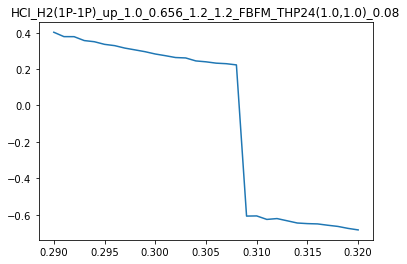

App THP24(THP): time consumed 2192.3393359184265s.


In [17]:
delta=0.0
parameters=OrderedDict()
parameters['t1']=1.0
parameters['t2']=0.29
parameters['phi']=0.656
parameters['Ua']=1.2
parameters['Ub']=parameters['Ua']-delta

T = 0.08
ns = [0]
params = hp.BaseSpace(('t2', np.linspace(0.29, 0.32, 31)))
fbfmtasks(name, parameters, lattice, [t,ci], [Ua,Ub], nk=24, scalefree=1.0, scaleint=1.0, jobs=['THP'], ns=ns, T=T, params=params)

HCI_H2(1P-1P)_up_1.0_0.656_1.2_1.2_FBFM_THP30(1.0,1.0)_0.08: 
OrderedDict([('t2', 0.29)]): [1.]
OrderedDict([('t2', 0.291)]): [1.]
OrderedDict([('t2', 0.292)]): [1.]
OrderedDict([('t2', 0.293)]): [1.]
OrderedDict([('t2', 0.294)]): [1.]
OrderedDict([('t2', 0.295)]): [1.]
OrderedDict([('t2', 0.296)]): [1.]
OrderedDict([('t2', 0.297)]): [1.]
OrderedDict([('t2', 0.298)]): [1.]
OrderedDict([('t2', 0.299)]): [1.]
OrderedDict([('t2', 0.3)]): [1.]
OrderedDict([('t2', 0.301)]): [1.]
OrderedDict([('t2', 0.302)]): [1.]
OrderedDict([('t2', 0.303)]): [1.]
OrderedDict([('t2', 0.304)]): [1.]
OrderedDict([('t2', 0.305)]): [1.]
OrderedDict([('t2', 0.306)]): [1.]
OrderedDict([('t2', 0.307)]): [1.]
OrderedDict([('t2', 0.308)]): [1.]
OrderedDict([('t2', 0.309)]): [-1.]
OrderedDict([('t2', 0.31)]): [-1.]
OrderedDict([('t2', 0.311)]): [-1.]
OrderedDict([('t2', 0.312)]): [-1.]
OrderedDict([('t2', 0.313)]): [-1.]
OrderedDict([('t2', 0.314)]): [-1.]
OrderedDict([('t2', 0.315)]): [-1.]
OrderedDict([('t2', 0.316

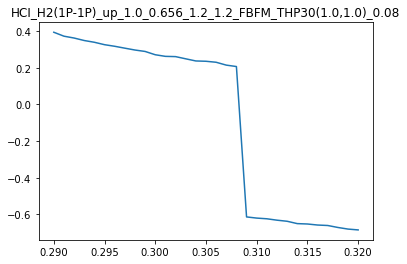

App THP30(THP): time consumed 9967.871411800385s.


In [18]:
delta=0.0
parameters=OrderedDict()
parameters['t1']=1.0
parameters['t2']=0.29
parameters['phi']=0.656
parameters['Ua']=1.2
parameters['Ub']=parameters['Ua']-delta

T = 0.08
ns = [0]
params = hp.BaseSpace(('t2', np.linspace(0.29, 0.32, 31)))
fbfmtasks(name, parameters, lattice, [t,ci], [Ua,Ub], nk=30, scalefree=1.0, scaleint=1.0, jobs=['THP'], ns=ns, T=T, params=params)

HCI_H2(1P-1P)_up_1.0_0.656_1.2_1.1_FBFM_THP30(1.0,1.0)_0.08: 
OrderedDict([('t2', 0.29)]): [1.]
OrderedDict([('t2', 0.291)]): [1.]
OrderedDict([('t2', 0.292)]): [1.]
OrderedDict([('t2', 0.293)]): [1.]
OrderedDict([('t2', 0.294)]): [1.]
OrderedDict([('t2', 0.295)]): [1.]
OrderedDict([('t2', 0.296)]): [1.]
OrderedDict([('t2', 0.297)]): [1.]
OrderedDict([('t2', 0.298)]): [1.]
OrderedDict([('t2', 0.299)]): [1.]
OrderedDict([('t2', 0.3)]): [1.]
OrderedDict([('t2', 0.301)]): [1.]
OrderedDict([('t2', 0.302)]): [1.]
OrderedDict([('t2', 0.303)]): [-5.63223225e-16]
OrderedDict([('t2', 0.304)]): [-1.10159837e-16]
OrderedDict([('t2', 0.305)]): [4.74874484e-17]
OrderedDict([('t2', 0.306)]): [-1.47155872e-16]
OrderedDict([('t2', 0.307)]): [1.20237115e-16]
OrderedDict([('t2', 0.308)]): [4.48922041e-16]
OrderedDict([('t2', 0.309)]): [-2.31363266e-16]
OrderedDict([('t2', 0.31)]): [2.69601705e-16]
OrderedDict([('t2', 0.311)]): [-4.67143969e-16]
OrderedDict([('t2', 0.312)]): [1.85532356e-16]
OrderedDict(

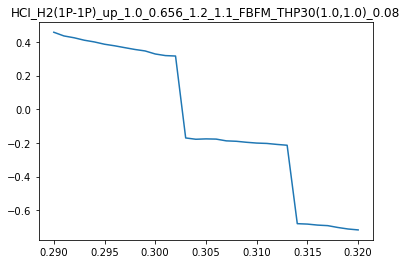

App THP30(THP): time consumed 10030.441970586777s.


In [7]:
delta=0.1
parameters=OrderedDict()
parameters['t1']=1.0
parameters['t2']=0.29
parameters['phi']=0.656
parameters['Ua']=1.2
parameters['Ub']=parameters['Ua']-delta

T = 0.08
ns = [0]
params = hp.BaseSpace(('t2', np.linspace(0.29, 0.32, 31)))
fbfmtasks(name, parameters, lattice, [t,ci], [Ua,Ub], nk=30, scalefree=1.0, scaleint=1.0, jobs=['THP'], ns=ns, T=T, params=params)